Recreating the Vision Transformer (ViT) computer vision architecture. More specifically, this is an implementation of "<a href="https://arxiv.org/abs/2010.11929">An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale</a>" ViT paper. The Transformer neural network architecture was originally introduced in the machine learning research paper "<a href="https://arxiv.org/abs/1706.03762">Attention is all you need</a>", which was designed to work on one-dimensional (1D) sequences of text.

A Transformer architecture is generally considered to be any neural network that uses the attention mechanism) as its primary learning layer. Similar to how a convolutional neural network (CNN) uses convolutions as its primary learning layer.

In [103]:
import torch
import torchvision
import matplotlib.pyplot as plt

from torchvision import transforms
from torchinfo import summary
import torch.nn as nn

assert int(torch.__version__.split(".")[1]) >= 12 or int(torch.__version__.split(".")[0]) == 2, "torch version should be 1.12+"
assert int(torchvision.__version__.split(".")[1]) >= 13, "torchvision version should be 0.13+"

from utils import engine, data
from utils.plots import plot_loss_curves

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#### Data Preparation

In [105]:
# Download pizza, steak, sushi images from GitHub
image_path = data.download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi") # location is appended to '/data' inside the function
image_path

[INFO] data/pizza_steak_sushi directory exists, skipping download.


PosixPath('data/pizza_steak_sushi')

In [106]:
# Setup directory paths to train and test images
train_dir = image_path / "train"
test_dir = image_path / "test"

In [107]:
train_dir

PosixPath('data/pizza_steak_sushi/train')

In [108]:
# Create image size (from Table 3 in the ViT paper)
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [109]:
# ViT paper states the use of a batch size of 4096 
# Note: We're using the pin_memory=True parameter in the create_dataloaders() function to speed up computation. 
# pin_memory=True avoids unnecessary copying of memory between the CPU and GPU memory by "pinning" examples that 
# have been seen before. Though the benefits of this will likely be seen with larger dataset sizes. However, setting 
# pin_memory=True doesn't always improve performance (this is another one of those we're scenarios in machine learning 
# where some things work sometimes and don't other times), so best to experiment.

# Set the batch size
BATCH_SIZE = 32 # this is lower than the ViT paper but it's because we're starting small

# Create data loaders
train_dataloader, test_dataloader, class_names = data.create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms, # use manually created transforms
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7fab9cbf3760>,
 ['pizza', 'steak', 'sushi'])

In [110]:
# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
image.shape, label

(torch.Size([3, 224, 224]), tensor(1))

(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

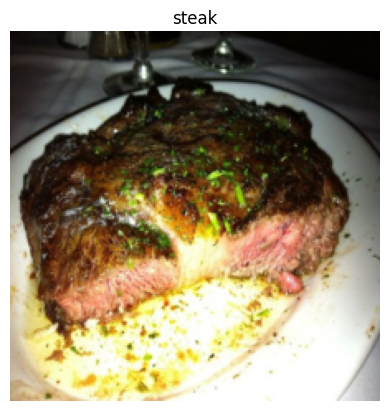

In [111]:
# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False)

#### ViT Model

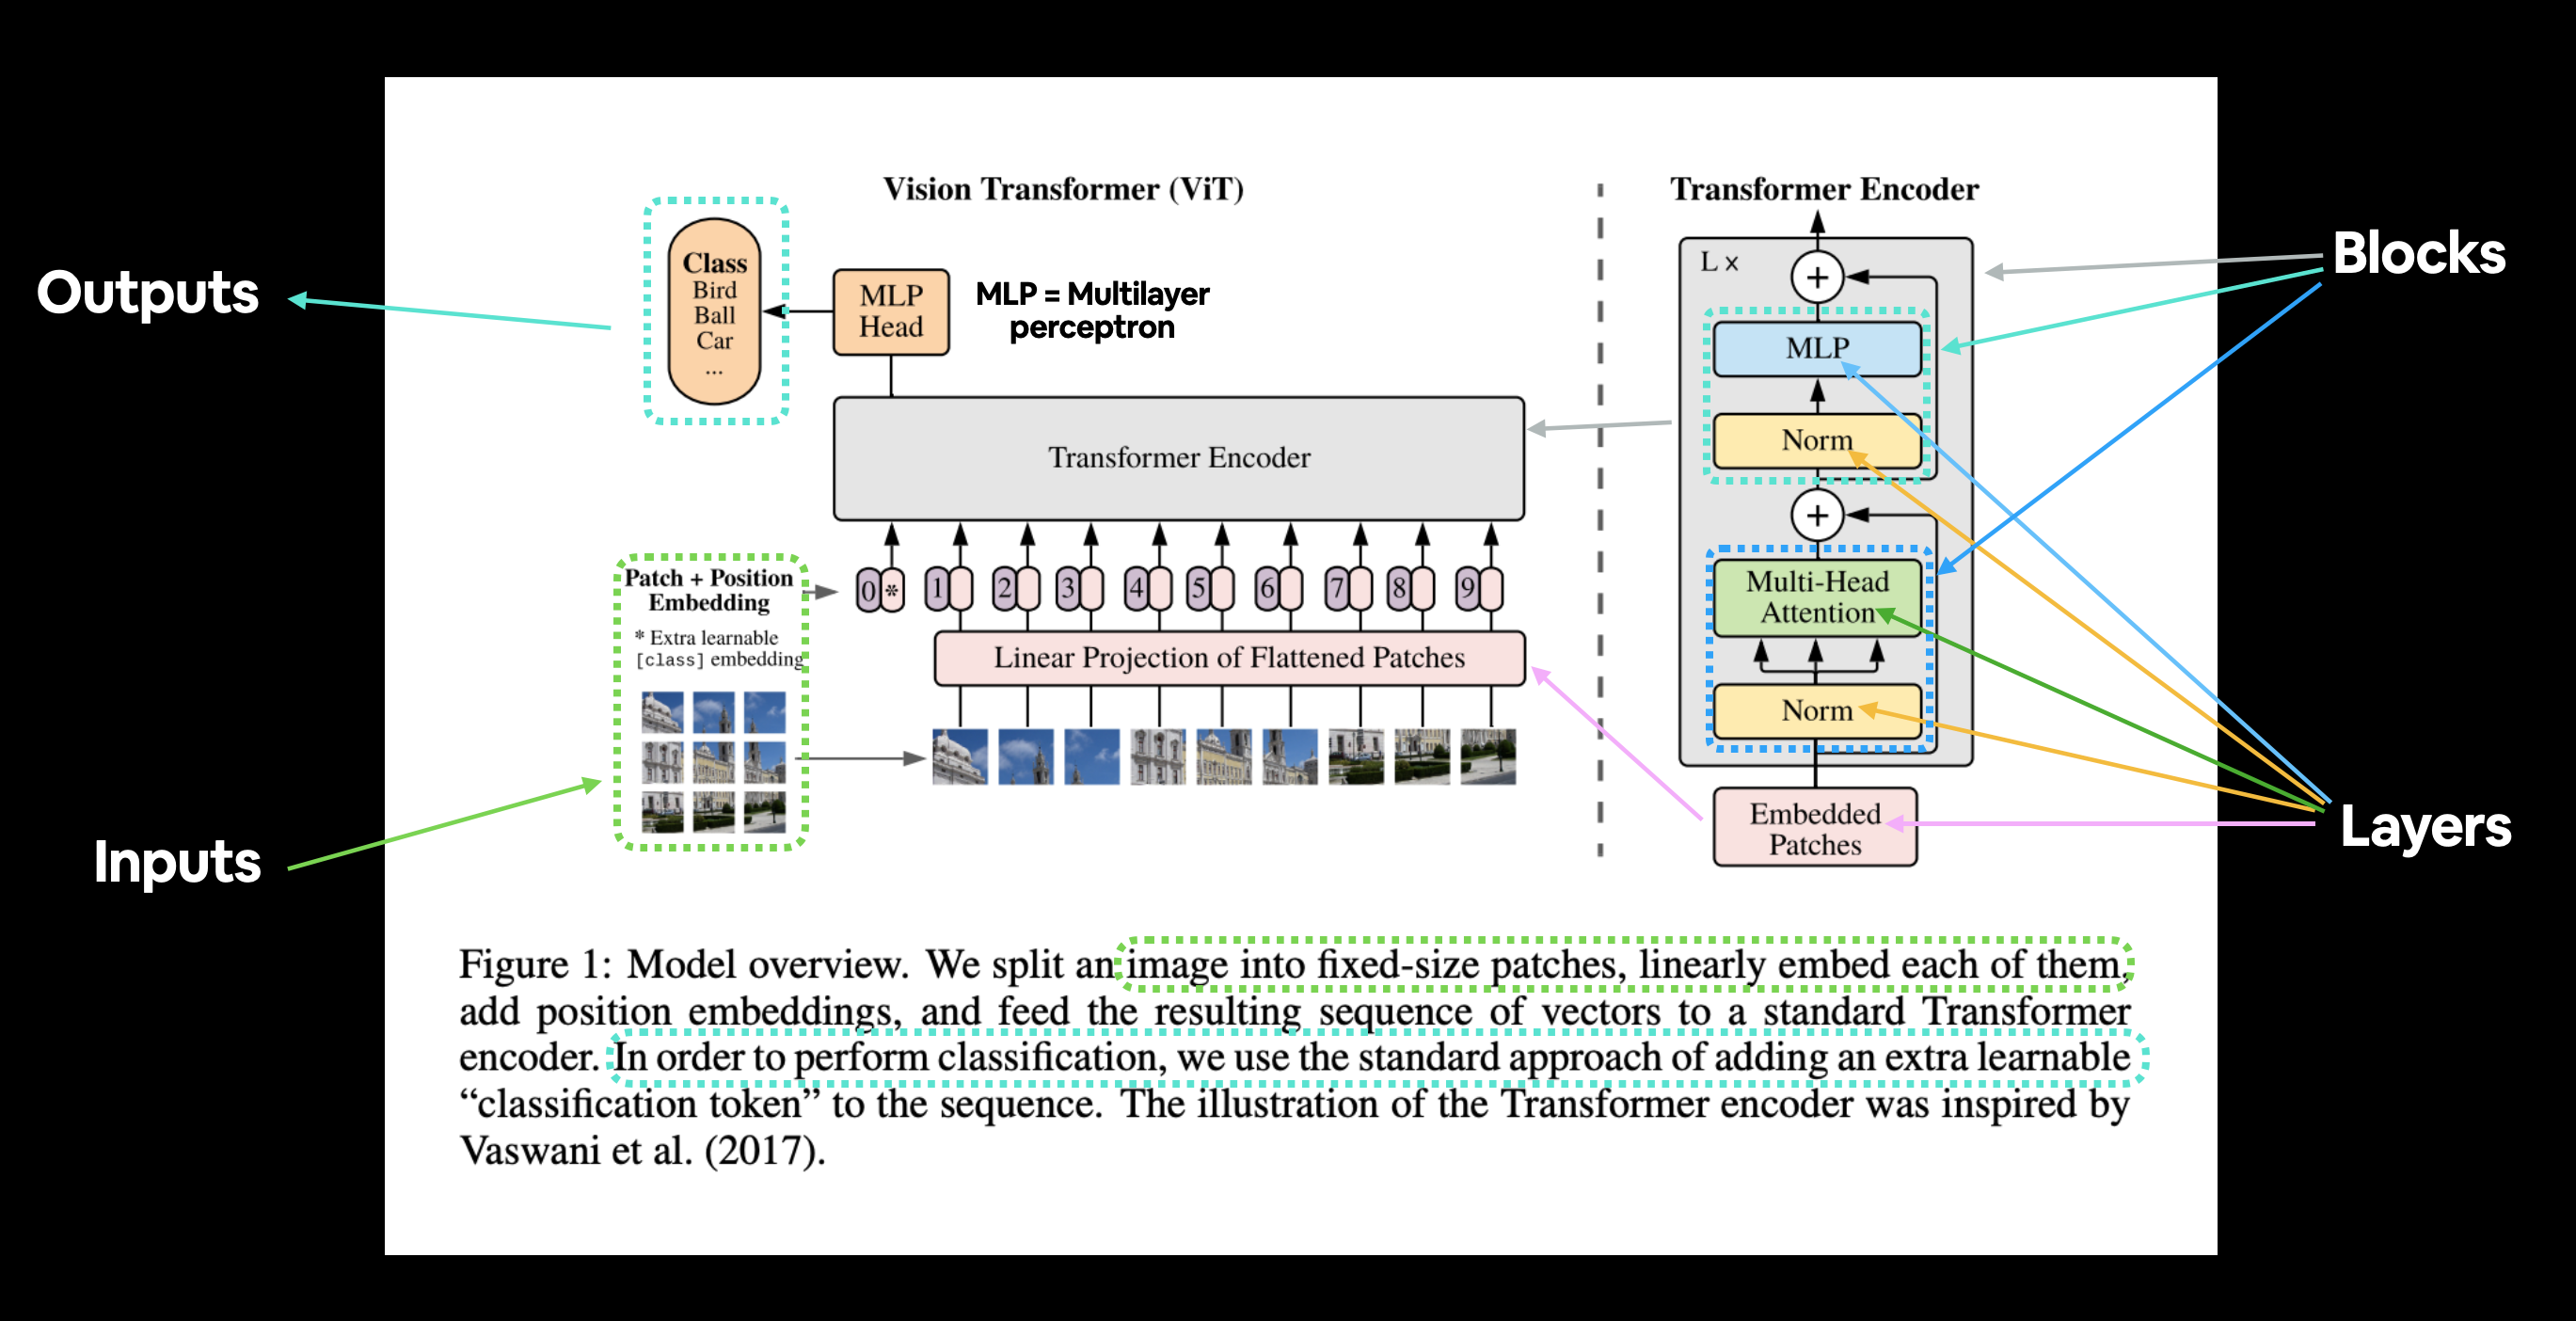

The ViT architecture is comprised of several stages:

* **Patch + Position Embedding (inputs)** - Turns the input image into a sequence of image patches and adds a position number to specify in what order the patch comes in.
* **Linear projection of flattened patches (Embedded Patches)** - The image patches get turned into an embedding, the benefit of using an embedding rather than just the image values is that an embedding is a learnable representation (typically in the form of a vector) of the image that can improve with training.
* **Norm** - This is short for "Layer Normalization" or "LayerNorm", a technique for regularizing (reducing overfitting) a neural network, you can use LayerNorm via the PyTorch layer `torch.nn.LayerNorm()`.
* **Multi-Head Attention** - This is a Multi-Headed Self-Attention layer or "MSA" for short. You can create an MSA layer via the PyTorch layer `torch.nn.MultiheadAttention()`.
* **MLP (or Multilayer perceptron)** - A MLP can often refer to any collection of feedforward layers (or in PyTorch's case, a collection of layers with a forward() method). In the ViT Paper, the authors refer to the MLP as "MLP block" and it contains two torch.nn.Linear() layers with a torch.nn.GELU() non-linearity activation in between them (section 3.1) and a torch.nn.Dropout() layer after each (Appendix B.1).
* **Transformer Encoder** - The Transformer Encoder, is a collection of the layers listed above. There are two skip connections inside the Transformer encoder (the "+" symbols) meaning the layer's inputs are fed directly to immediate layers as well as subsequent layers. The overall ViT architecture is comprised of a number of Transformer encoders stacked on top of eachother.
* **MLP Head** - This is the output layer of the architecture, it converts the learned features of an input to a class output. Since we're working on image classification, you could also call this the "classifier head". The structure of the MLP Head is similar to the MLP block.

#### Equation 1: Split data into patches and creating the class, position and patch embedding

$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$

This equation deals with the class token, patch embedding and position embedding ($\mathbf{E}$ is for embedding) of the input image.

In vector form, the embedding might look something like:

```python
x_input = [class_token, image_patch_1, image_patch_2, image_patch_3...] + [class_token_position, image_patch_1_position, image_patch_2_position, image_patch_3_position...]
```

From the paper:

> The standard Transformer receives as input a 1D sequence of token embeddings. To handle 2D images, we reshape the image $\mathbf{x} \in \mathbb{R}^{H \times W \times C}$ into a sequence of flattened 2D patches $\mathbf{x}_{p} \in \mathbb{R}^{N \times\left(P^{2} \cdot C\right)}$, where $(H, W)$ is the resolution of the original image, $C$ is the number of channels, $(P, P)$ is the resolution of each image patch, and $N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer. The Transformer uses constant latent vector size $D$ through all of its layers, so we flatten the patches and map to $D$ dimensions with a trainable linear projection (Eq. 1). We refer to the output of this projection as the **patch embeddings**.

* $D$ is the size of the patch embeddings, different values for $D$ for various sized ViT models can be found in Table 1.
The image starts as 2D with size ${H \times W \times C}$.
* $(H, W)$ is the resolution of the original image (height, width).
    * $C$ is the number of channels.
    * The image gets converted to a sequence of flattened 2D patches with size ${N \times\left(P^{2} \cdot C\right)}$.
* $(P, P)$ is the resolution of each image patch (patch size).
* $N=H W / P^{2}$ is the resulting number of patches, which also serves as the input sequence length for the Transformer.


Image size = (H,W,C) -> (N_Patches, ($P^{2}$ $\times$ C)). For example, patch size = 16 (ViT Base): 
(224, 224, 3) -> ( (224//16)$\times$(224//16) , (16$\times$16$\times$3) ) = (196, 768).

The 196 patches came from the number of patches of size 16$\times$16 in a 224 $\times$ 224 image.

In [112]:
# Create example values
height = 224 # H ("The training resolution is 224.")
width = 224 # W
color_channels = 3 # C
patch_size = 16 # P as in Table 5 of the ViT-B/16 paper

# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)
print(f"Number of patches (N) with image height (H={height}), width (W={width}) and patch size (P={patch_size}): {number_of_patches}")

Number of patches (N) with image height (H=224), width (W=224) and patch size (P=16): 196


In [113]:
# Input shape (this is the size of a single image)
embedding_layer_input_shape = (height, width, color_channels)

# Output shape
embedding_layer_output_shape = (number_of_patches, patch_size**2 * color_channels)

print(f"Input shape (single 2D image): {embedding_layer_input_shape}")
print(f"Output shape (single 2D image flattened into patches): {embedding_layer_output_shape}")

Input shape (single 2D image): (224, 224, 3)
Output shape (single 2D image flattened into patches): (196, 768)


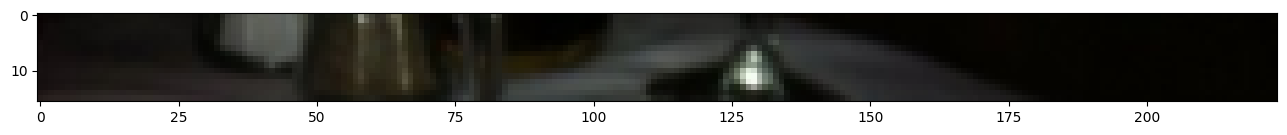

In [114]:
# Change image shape to be compatible with matplotlib (color_channels/0, height/1, width/2) -> (height/1, width/2, color_channels/0)
image_permuted = image.permute(1, 2, 0)

# Index to plot the top row of patched pixels
patch_size = 16
plt.figure(figsize=(patch_size, patch_size))
plt.imshow(image_permuted[:patch_size, :, :]);

Number of patches per row: 14.0
Patch size: 16 pixels x 16 pixels


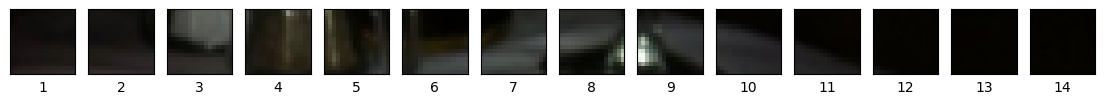

In [115]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=1,
                        ncols=img_size // patch_size, # one column for each patch
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Iterate through number of patches in the top row
for i, patch in enumerate(range(0, img_size, patch_size)):
    axs[i].imshow(image_permuted[:patch_size, patch:patch+patch_size, :]); # keep height index constant, alter the width index
    axs[i].set_xlabel(i+1) # set the label
    axs[i].set_xticks([])
    axs[i].set_yticks([])

Number of patches per row: 14.0        
Number of patches per column: 14.0        
Total patches: 196.0        
Patch size: 16 pixels x 16 pixels


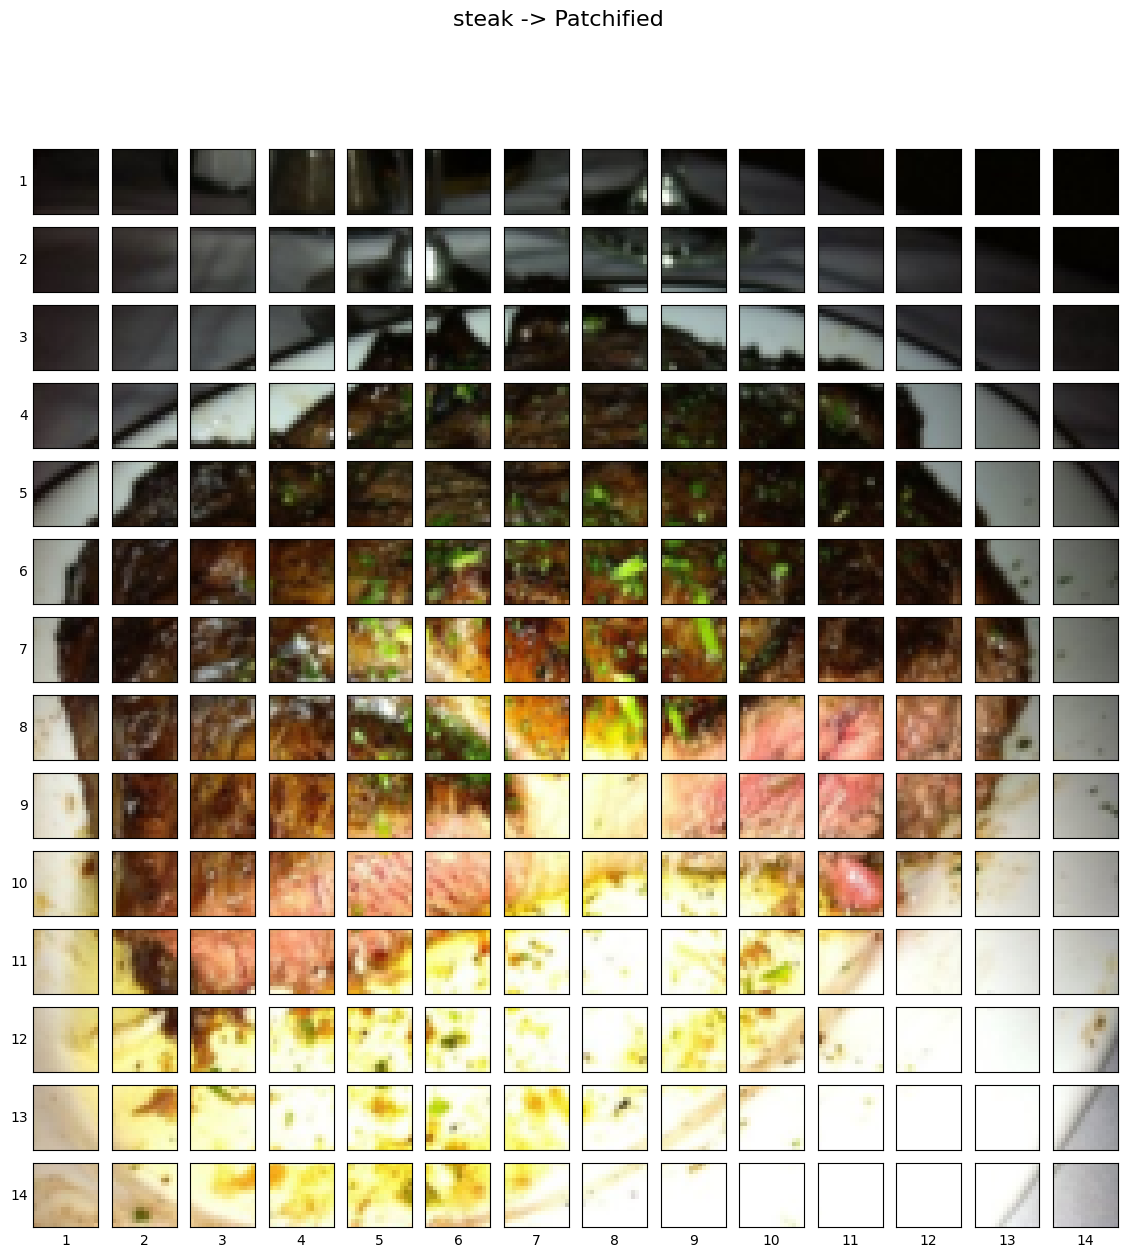

In [116]:
# Setup hyperparameters and make sure img_size and patch_size are compatible
img_size = 224
patch_size = 16
num_patches = img_size/patch_size
assert img_size % patch_size == 0, "Image size must be divisible by patch size"
print(f"Number of patches per row: {num_patches}\
        \nNumber of patches per column: {num_patches}\
        \nTotal patches: {num_patches*num_patches}\
        \nPatch size: {patch_size} pixels x {patch_size} pixels")

# Create a series of subplots
fig, axs = plt.subplots(nrows=img_size // patch_size, # need int not float
                        ncols=img_size // patch_size,
                        figsize=(num_patches, num_patches),
                        sharex=True,
                        sharey=True)

# Loop through height and width of image
for i, patch_height in enumerate(range(0, img_size, patch_size)): # iterate through height
    for j, patch_width in enumerate(range(0, img_size, patch_size)): # iterate through width

        # Plot the permuted image patch (image_permuted -> (Height, Width, Color Channels))
        axs[i, j].imshow(image_permuted[patch_height:patch_height+patch_size, # iterate through height
                                        patch_width:patch_width+patch_size, # iterate through width
                                        :]) # get all color channels

        # Set up label information, remove the ticks for clarity and set labels to outside
        axs[i, j].set_ylabel(i+1,
                             rotation="horizontal",
                             horizontalalignment="right",
                             verticalalignment="center")
        axs[i, j].set_xlabel(j+1)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])
        axs[i, j].label_outer()

# Set a super title
fig.suptitle(f"{class_names[label]} -> Patchified", fontsize=16)
plt.show()

**Creating image patches with `torch.nn.Conv2d()`**

For an image size of 224 and patch size of 16:

* Input (2D image): (224, 224, 3) -> (height, width, color channels)
* Output (flattened 2D patches): (196, 768) -> (number of patches, embedding dimension)

We can recreate these with:

* `torch.nn.Conv2d()` for turning our image into patches of CNN feature maps.
* `torch.nn.Flatten()` for flattening the spatial dimensions of the feature map.

This means each convolutional kernel will be of size (patch_size x patch_size) or if `patch_size=16, (16 x 16)` (the equivalent of one whole patch). And each step or stride of the convolutional kernel will be `patch_size` pixels long or 16 pixels long (equivalent of stepping to the next patch).

We'll set `in_channels=3` for the number of color channels in our image and we'll set out_channels=768, the same as the $D$ value in Table 1 for ViT-Base (this is the embedding dimension, each image will be embedded into a learnable vector of size 768).

In [117]:
# Set the patch size
patch_size=16

# Create the Conv2d layer with hyperparameters from the ViT paper
conv2d = nn.Conv2d(in_channels=3, # number of color channels
                   out_channels=768, # from Table 1: Hidden size D, this is the embedding size
                   kernel_size=patch_size, # could also use (patch_size, patch_size)
                   stride=patch_size,
                   padding=0)

In [118]:
# Pass the image through the convolutional layer
image_out_of_conv = conv2d(image.unsqueeze(0)) # add a single batch dimension (height, width, color_channels) -> (batch, height, width, color_channels)
print(image_out_of_conv.shape)

torch.Size([1, 768, 14, 14])


The output of the convolution patches can be expressed as 

```python
torch.Size([1, 768, 14, 14]) -> [batch_size, embedding_dim, feature_map_height, feature_map_width]
```

Let's visualize five random feature maps and see what they look like.

Showing random convolutional feature maps from indexes: [557, 757, 245, 527, 370]


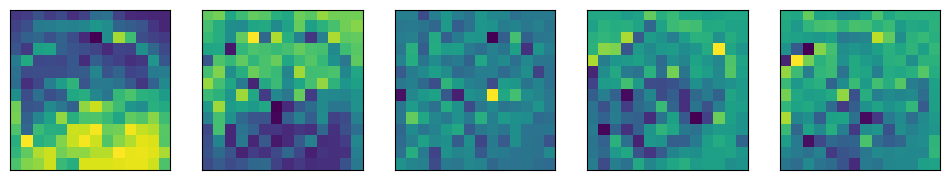

In [119]:

# Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0, 767), k=5) # pick 5 numbers between 0 and the embedding size
print(f"Showing random convolutional feature maps from indexes: {random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1, ncols=5, figsize=(12, 12))

# Plot random image feature maps
for i, idx in enumerate(random_indexes):
    image_conv_feature_map = image_out_of_conv[:, idx, :, :] # index on the output tensor of the convolutional layer
    axs[i].imshow(image_conv_feature_map.squeeze().detach().numpy())
    axs[i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[]);


In [120]:
# Get a single feature map in tensor form
single_feature_map = image_out_of_conv[:, 0, :, :]
single_feature_map, single_feature_map.requires_grad

(tensor([[[ 0.0457,  0.0612,  0.1892,  0.0968,  0.0544,  0.0073,  0.1131,
           -0.0075,  0.0865,  0.0237,  0.0360,  0.0207,  0.0087,  0.0099],
          [ 0.0800,  0.1151,  0.1030,  0.0814,  0.0858,  0.2055,  0.0712,
            0.0347,  0.0477,  0.0687,  0.0619,  0.0288,  0.0154,  0.0313],
          [ 0.0665,  0.1096,  0.1234,  0.1588,  0.0643,  0.0732, -0.0263,
            0.1686,  0.2775, -0.0248,  0.1081,  0.1804,  0.0553,  0.0422],
          [ 0.0933,  0.1357,  0.0993,  0.1539, -0.0640,  0.0845,  0.0095,
            0.0461,  0.0242,  0.0655,  0.0780,  0.2601,  0.1520,  0.0831],
          [ 0.1467,  0.1096,  0.0974,  0.0615,  0.0911,  0.0927,  0.1106,
            0.1820,  0.0599,  0.0071,  0.0319,  0.0751,  0.1035,  0.1242],
          [ 0.1980,  0.1289,  0.0310,  0.1123,  0.1600,  0.1741,  0.1046,
            0.0866,  0.1444,  0.0773,  0.0470,  0.0379,  0.3221,  0.1815],
          [ 0.0976,  0.0055,  0.1451,  0.2944,  0.2000,  0.3556,  0.1329,
            0.1726,  0.1839,  0.

We've turned our image into patch embeddings but they're still in 2D format. To get them into the desired output shape (1D sequence of flatten 2D patches): (196, 768) -> (number of patches, embedding dimension), we can flatten them:

In [121]:
print(f"Current tensor shape: {image_out_of_conv.shape} -> [batch, embedding_dim, feature_map_height, feature_map_width]")

Current tensor shape: torch.Size([1, 768, 14, 14]) -> [batch, embedding_dim, feature_map_height, feature_map_width]


In [122]:
# Create flatten layer
flatten = nn.Flatten(start_dim=2, # flatten feature_map_height (dimension 2)
                     end_dim=3) # flatten feature_map_width (dimension 3)

Original image shape: torch.Size([3, 224, 224])
Image feature map shape: torch.Size([1, 768, 14, 14])
Flattened image feature map shape: torch.Size([1, 768, 196])


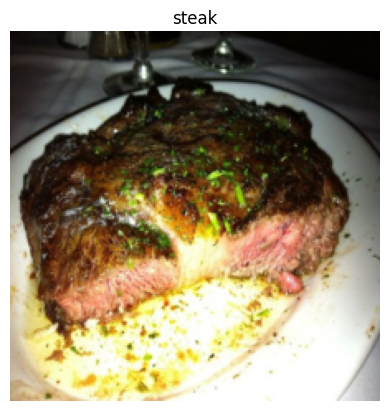

In [123]:
# 1. View single image
plt.imshow(image.permute(1, 2, 0)) # adjust for matplotlib
plt.title(class_names[label])
plt.axis(False);
print(f"Original image shape: {image.shape}")

# 2. Turn image into feature maps
image_out_of_conv = conv2d(image.unsqueeze(0)) # add batch dimension to avoid shape errors
print(f"Image feature map shape: {image_out_of_conv.shape}")

# 3. Flatten the feature maps
image_out_of_conv_flattened = flatten(image_out_of_conv)
print(f"Flattened image feature map shape: {image_out_of_conv_flattened.shape}")

In [124]:
# Get flattened image patch embeddings in right shape
image_out_of_conv_flattened_reshaped = image_out_of_conv_flattened.permute(0, 2, 1) # [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]
print(f"Patch embedding sequence shape: {image_out_of_conv_flattened_reshaped.shape} -> [batch_size, num_patches, embedding_size]")

Patch embedding sequence shape: torch.Size([1, 196, 768]) -> [batch_size, num_patches, embedding_size]


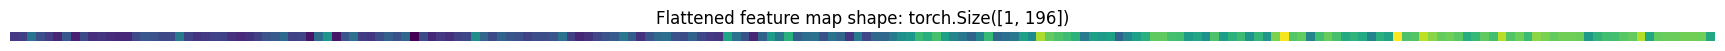

In [125]:
# Get a single flattened feature map and visualize it (visualize one feature/component across all patches for each image in the batch)
# This looks at a single feature/component (e.g., like a single neuron activation) across all patches.
# In other words, “What does the first embedding feature look like spatially across the image?”
single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, :, 0] # index: (batch_size, number_of_patches, embedding_dimension)

# Selects the first patch (e.g., top-left of the image if patches are ordered that way) and gets all embedding features for that one patch.
# single_flattened_feature_map = image_out_of_conv_flattened_reshaped[:, 0, :] # index: (batch_size, number_of_patches, embedding_dimension)
# We’re looking at all the features for just one patch — not a spatial map.
# In other words, “What is the full embedding vector for the first patch?”

# Plot the flattened feature map visually
plt.figure(figsize=(22, 22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f"Flattened feature map shape: {single_flattened_feature_map.shape}")
plt.axis(False);

In [126]:
class PatchEmbedding(nn.Module):
    """Turns a 2D input image into a 1D sequence learnable embedding vector.

    Args:
        in_channels (int): Number of color channels for the input images. Defaults to 3.
        patch_size (int): Size of patches to convert input image into. Defaults to 16.
        embedding_dim (int): Size of embedding to turn image into. Defaults to 768.
    """
    # 2. Initialize the class with appropriate variables
    def __init__(self,
                 in_channels:int=3,
                 patch_size:int=16,
                 embedding_dim:int=768):
        super().__init__()

        # 3. Create a layer to turn an image into patches
        self.patcher = nn.Conv2d(in_channels=in_channels,
                                 out_channels=embedding_dim,
                                 kernel_size=patch_size,
                                 stride=patch_size,
                                 padding=0)

        # 4. Create a layer to flatten the patch feature maps into a single dimension
        self.flatten = nn.Flatten(start_dim=2, # only flatten the feature map dimensions into a single vector
                                  end_dim=3)

    # 5. Define the forward method
    def forward(self, x):
        # Create assertion to check that inputs are the correct shape
        image_resolution = x.shape[-1]
        assert image_resolution % patch_size == 0, f"Input image size must be divisible by patch size, image shape: {image_resolution}, patch size: {patch_size}"

        # Perform the forward pass
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        # 6. Make sure the output shape has the right order
        return x_flattened.permute(0, 2, 1) # adjust so the embedding is on the final dimension [batch_size, P^2•C, N] -> [batch_size, N, P^2•C]

In [127]:
# Create random input sizes
random_input_image = (1, 3, 224, 224)
random_input_image_error = (1, 3, 250, 250) # will error because image size is incompatible with patch_size

# Get a summary of the input and outputs of PatchEmbedding (uncomment for full output)
summary(PatchEmbedding(),
        input_size=random_input_image, # try swapping this for "random_input_image_error"
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
PatchEmbedding (PatchEmbedding)          [1, 3, 224, 224]     [1, 196, 768]        --                   True
├─Conv2d (patcher)                       [1, 3, 224, 224]     [1, 768, 14, 14]     590,592              True
├─Flatten (flatten)                      [1, 768, 14, 14]     [1, 768, 196]        --                   --
Total params: 590,592
Trainable params: 590,592
Non-trainable params: 0
Total mult-adds (M): 115.76
Input size (MB): 0.60
Forward/backward pass size (MB): 1.20
Params size (MB): 2.36
Estimated Total Size (MB): 4.17

In [128]:
for p, n in PatchEmbedding().named_parameters():
    print(p, n.requires_grad)

patcher.weight True
patcher.bias True


In [129]:
# Let's try with a single batch sample
engine.set_seeds()

# Create an instance of patch embedding layer
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

# Pass a single image through
print(f"Input image shape: {image.unsqueeze(0).shape}")
patch_embedded_image = patchify(image.unsqueeze(0)) # add an extra batch dimension on the 0th index, otherwise will error
print(f"Output patch embedding shape: {patch_embedded_image.shape} -> [batch_size, number_of_patches, embedding_dimension]")

Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Note that in the above cell, we can see the correct output shape after the `permute` operation for the shape size, compared with viewing the model summary.

**We've now replicated the patch embedding for equation 1 but not the class token/position embedding.**

**Creating the class token embedding** - $\mathbf{x}_\text {class }$ from equation 1.

> Similar to BERT's [ class ] token, we prepend a learnable embedding to the sequence of embedded patches $\left(\mathbf{z}_{0}^{0}=\mathbf{x}_{\text {class }}\right)$, whose state at the output of the Transformer encoder $\left(\mathbf{z}_{L}^{0}\right)$ serves as the image representation $\mathbf{y}$ (Eq. 4).



> Note: BERT (Bidirectional Encoder Representations from Transformers) is one of the original machine learning research papers to use the Transformer architecture to achieve outstanding results on natural language processing (NLP) tasks and is where the idea of having a [ class ] token at the start of a sequence originated, class being a description for the "classification" class the sequence belonged to.



To "prepend a learnable embedding to the sequence of embedded patches" we need to create a learnable embedding in the shape of the embedding_dimension ($D$) and then add it to the number_of_patches dimension.

```python
patch_embedding = [image_patch_1, image_patch_2, image_patch_3...]
class_token = learnable_embedding
patch_embedding_with_class_token = torch.cat((class_token, patch_embedding), dim=1)

```

Notice the concatenation (torch.cat()) happens on dim=1 (the number_of_patches dimension).

To do so, we'll get the batch size and embedding dimension shape and then we'll create a torch.ones() tensor in the shape `[batch_size, 1, embedding_dimension]`.

In [130]:
# Get the batch size and embedding dimension
batch_size = patch_embedded_image.shape[0]
embedding_dimension = patch_embedded_image.shape[-1]

class_token = nn.Parameter(
    torch.ones(batch_size, 1, embedding_dimension), # in practice, we'd likely create it with torch.randn()
    requires_grad=True)

# Show the first 10 examples of the class_token
print(class_token[:, :, :10])

# Print the class_token shape
print(f"Class token shape: {class_token.shape} -> [batch_size, number_of_tokens, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Class token shape: torch.Size([1, 1, 768]) -> [batch_size, number_of_tokens, embedding_dimension]


> Here we're only creating the class token embedding as torch.ones() for demonstration purposes, in reality, you'd likely create the class token embedding with torch.randn() (since machine learning is all about harnessing the power of controlled randomness, you generally start with a random number and improve it over time).

See how the `number_of_tokens` dimension of `class_token` is 1 since we only want to prepend one class token value to the start of the patch embedding sequence. Now we've got the class token embedding, let's prepend it to our sequence of image patches, patch_embedded_image. We can do so using `torch.cat()` and set dim=1 (so `class_token`'s `number_of_tokens` dimension is prepended to `patch_embedded_image`'s number_of_patches dimension).

In [131]:
# Add the class token embedding to the front of the patch embedding
patch_embedded_image_with_class_embedding = torch.cat((class_token, patch_embedded_image),
                                                      dim=1) # concat on first dimension to add a new row in the matrix

# Print the sequence of patch embeddings with the prepended class token embedding
print(patch_embedded_image_with_class_embedding)
print(f"Sequence of patch embeddings with class token prepended shape: {patch_embedded_image_with_class_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
         [-0.1120,  0.0180, -0.0760,  ...,  0.0717, -0.0175,  0.0345],
         [-0.1117,  0.0086, -0.0886,  ...,  0.1076, -0.0259,  0.0413],
         ...,
         [-1.0385,  0.2844, -0.2902,  ...,  0.7915, -0.4702,  0.3662],
         [-0.9770,  0.2183, -0.2821,  ...,  0.7555, -0.3986,  0.3719],
         [-0.7081,  0.1448, -0.2540,  ...,  0.5537, -0.3293,  0.3151]]],
       grad_fn=<CatBackward0>)
Sequence of patch embeddings with class token prepended shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


**Creating the position embedding**

We've got the class token embedding and the patch embedding, we can now create the position embedding - $\mathbf{E}_{\text {pos }}$ from equation 1 where $E$ stands for "embedding".



> Position embeddings are added to the patch embeddings to retain positional information. We use standard learnable 1D position embeddings, since we have not observed significant performance gains from using more advanced 2D-aware position embeddings (Appendix D.4). The resulting sequence of embedding vectors serves as input to the encoder.

By "retain positional information" the authors mean they want the architecture to know what "order" the patches come in. As in, patch two comes after patch one and patch three comes after patch two and on and on.

This positional information can be important when considering what's in an image (without positional information and a flattened sequence could be seen as having no order and thus no patch relates to any other patch).

To start creating the position embeddings, let's view our current embeddings.

In [132]:
# View the sequence of patch embeddings with the prepended class embedding
patch_embedded_image_with_class_embedding, patch_embedded_image_with_class_embedding.shape

(tensor([[[ 1.0000,  1.0000,  1.0000,  ...,  1.0000,  1.0000,  1.0000],
          [-0.1120,  0.0180, -0.0760,  ...,  0.0717, -0.0175,  0.0345],
          [-0.1117,  0.0086, -0.0886,  ...,  0.1076, -0.0259,  0.0413],
          ...,
          [-1.0385,  0.2844, -0.2902,  ...,  0.7915, -0.4702,  0.3662],
          [-0.9770,  0.2183, -0.2821,  ...,  0.7555, -0.3986,  0.3719],
          [-0.7081,  0.1448, -0.2540,  ...,  0.5537, -0.3293,  0.3151]]],
        grad_fn=<CatBackward0>),
 torch.Size([1, 197, 768]))

Equation 1 states that the position embeddings ($\mathbf{E}_{\text {pos }}$) should have the shape $(N + 1) \times D$:

$$\mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D}$$

Where:

$N=H W / P^{2}$ is the resulting number of patches, which also serves as the effective input sequence length for the Transformer (number of patches).
$D$ is the size of the patch embeddings, different values for $D$ can be found in Table 1 (embedding dimension).

So let's make a learnable 1D embedding with torch.ones() to create $\mathbf{E}_{\text {pos }}$.

In [133]:
# Calculate N (number of patches)
number_of_patches = int((height * width) / patch_size**2)

# Get embedding dimension
embedding_dimension = patch_embedded_image_with_class_embedding.shape[2]

# Create the learnable 1D position embedding
# You'd likely create the position embedding with torch.randn() (start with a random number and improve via gradient descent).
position_embedding = nn.Parameter(torch.ones(1,
                                             number_of_patches+1,
                                             embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# Show the first 10 sequences and 10 position embedding values and check the shape of the position embedding
print(position_embedding[:, :10, :10])
print(f"Position embedding shape: {position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
         [1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]]], grad_fn=<SliceBackward0>)
Position embedding shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


> Only creating the position embedding as torch.ones() for demonstration purposes, in reality, you'd likely create the position embedding with torch.randn() (start with a random number and improve via gradient descent).

Let's add them to our sequence of patch embeddings with a prepended class token.

In [134]:
# Add the position embedding to the patch and class token embedding
patch_and_position_embedding = patch_embedded_image_with_class_embedding + position_embedding
print(patch_and_position_embedding)
print(f"Patch embeddings, class token prepended and positional embeddings added shape: {patch_and_position_embedding.shape} -> [batch_size, number_of_patches, embedding_dimension]")

tensor([[[ 2.0000,  2.0000,  2.0000,  ...,  2.0000,  2.0000,  2.0000],
         [ 0.8880,  1.0180,  0.9240,  ...,  1.0717,  0.9825,  1.0345],
         [ 0.8883,  1.0086,  0.9114,  ...,  1.1076,  0.9741,  1.0413],
         ...,
         [-0.0385,  1.2844,  0.7098,  ...,  1.7915,  0.5298,  1.3662],
         [ 0.0230,  1.2183,  0.7179,  ...,  1.7555,  0.6014,  1.3719],
         [ 0.2919,  1.1448,  0.7460,  ...,  1.5537,  0.6707,  1.3151]]],
       grad_fn=<AddBackward0>)
Patch embeddings, class token prepended and positional embeddings added shape: torch.Size([1, 197, 768]) -> [batch_size, number_of_patches, embedding_dimension]


Notice how the values of each of the elements in the embedding tensor increases by 1 (this is because of the position embeddings being created with `torch.ones()`).

**Putting it all together: from image to embedding**

$$ \begin{aligned} \mathbf{z}_{0} &=\left[\mathbf{x}_{\text {class }} ; \mathbf{x}_{p}^{1} \mathbf{E} ; \mathbf{x}_{p}^{2} \mathbf{E} ; \cdots ; \mathbf{x}_{p}^{N} \mathbf{E}\right]+\mathbf{E}_{\text {pos }}, & & \mathbf{E} \in \mathbb{R}^{\left(P^{2} \cdot C\right) \times D}, \mathbf{E}_{\text {pos }} \in \mathbb{R}^{(N+1) \times D} \end{aligned} $$

Let's now put everything together in a single code cell and go from input image ($\mathbf{x}$) to output embedding ($\mathbf{z}_0$).

In [135]:
engine.set_seeds()

# 1. Set patch size
patch_size = 16

# 2. Print shape of original image tensor and get the image dimensions
print(f"Image tensor shape: {image.shape}")
height, width = image.shape[1], image.shape[2]

# 3. Get image tensor and add batch dimension
x = image.unsqueeze(0)
print(f"Input image with batch dimension shape: {x.shape}")

# 4. Create patch embedding layer
patch_embedding_layer = PatchEmbedding(in_channels=3,
                                       patch_size=patch_size,
                                       embedding_dim=768)

# 5. Pass image through patch embedding layer
patch_embedding = patch_embedding_layer(x)
print(f"Patching embedding shape: {patch_embedding.shape}")

# 6. Create class token embedding
batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.ones(batch_size, 1, embedding_dimension),
                           requires_grad=True) # make sure it's learnable
print(f"Class token embedding shape: {class_token.shape}")

# 7. Prepend class token embedding to patch embedding
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)
print(f"Patch embedding with class token shape: {patch_embedding_class_token.shape}")

# 8. Create position embedding
number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.ones(1, number_of_patches+1, embedding_dimension),
                                  requires_grad=True) # make sure it's learnable

# 9. Add position embedding to patch embedding with class token
patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")

Image tensor shape: torch.Size([3, 224, 224])
Input image with batch dimension shape: torch.Size([1, 3, 224, 224])
Patching embedding shape: torch.Size([1, 196, 768])
Class token embedding shape: torch.Size([1, 1, 768])
Patch embedding with class token shape: torch.Size([1, 197, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


#### Equation 2: Multi-Head Attention (MSA)

$$ \begin{aligned} \mathbf{z}_{\ell}^{\prime} &=\operatorname{MSA}\left(\operatorname{LN}\left(\mathbf{z}_{\ell-1}\right)\right)+\mathbf{z}_{\ell-1}, & & \ell=1 \ldots L \end{aligned} $$

This indicates a Multi-Head Attention (MSA) layer wrapped in a LayerNorm (LN) layer with a residual connection (the input to the layer gets added to the output of the layer). Layer Normalization helps improve training time and model generalization (ability to adapt to unseen data). I like to think of any kind of normalization as "getting the data into a similar format" or "getting data samples into a similar distribution".

If a single integer is used in `torch.nn.LayerNorm`, it is treated as a singleton list, and this module will normalize over the last dimension which is expected to be of that specific size.

The power of the **self-attention and multi-head attention (self-attention applied multiple times)** were revealed in the form of the original Transformer architecture introduced in the "Attention is all you need" paper.

Originally designed for text inputs, the original self-attention mechanism takes a sequence of words and then calculates which word should pay more "attention" to another word. In other words, in the sentence "the dog jumped over the fence", perhaps the word "dog" relates strongly to "jumped" and "fence".

This is simplified but the premise remains for images. Since our input is a sequence of image patches rather than words, self-attention and in turn multi-head attention will calculate which patch of an image is most related to another patch, eventually forming a learned representation of an image. But what's most important is that the layer does this on its own given the data (we don't tell it what patterns to learn). And if the learned representation the layers form using MSA are good, we'll see the results in our model's performance.



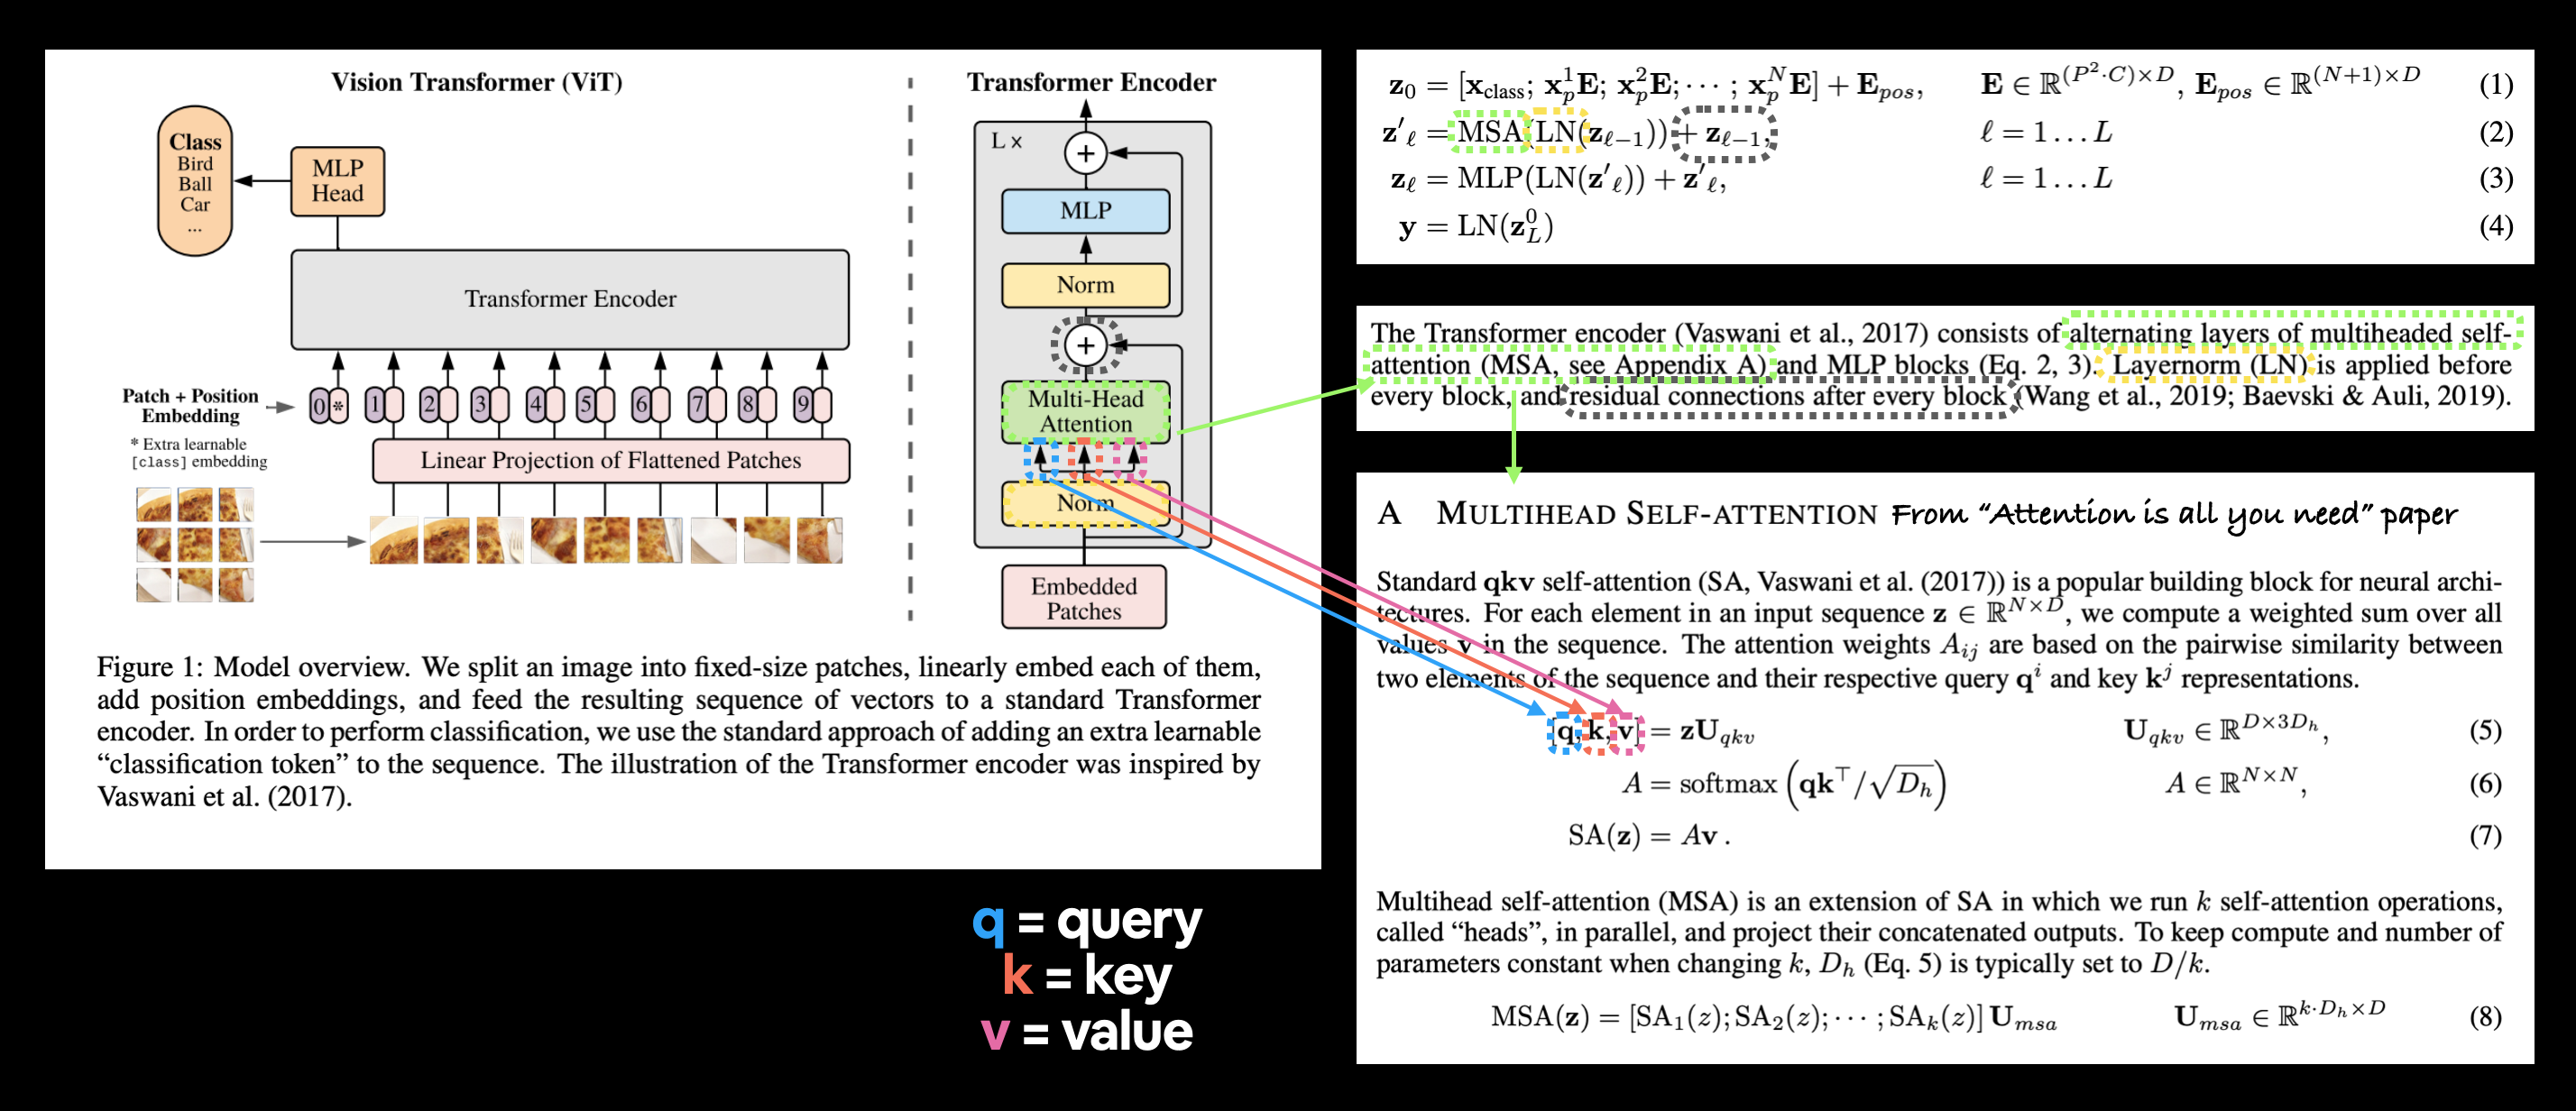

The image above highlights the **triple embedding input to the MSA layer**. This is known as query, key, value input or qkv for short which is fundamental to the self-attention mechanism.  In our case, the triple embedding input will be three versions of the output of the Norm layer, one for query, key and value. Or three versions of our layer-normalized image patch and position embeddings created before.

In [136]:
# 1. Create a class that inherits from nn.Module
class MultiheadSelfAttentionBlock(nn.Module):
    """Creates a multi-head self-attention block ("MSA block" for short).
    """
    # 2. Initialize the class with hyperparameters from Table 1
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0): # doesn't look like the paper uses any dropout in MSABlocks
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multi-Head Attention (MSA) layer
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True) # does our batch dimension come first?

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, # query embeddings
                                             key=x, # key embeddings
                                             value=x, # value embeddings
                                             need_weights=False) # do we need the weights or just the layer outputs?
        return attn_output

Our `MultiheadSelfAttentionBlock` **doesn't include a skip or residual connection ("$+\mathbf{z}_{\ell-1}$" in equation 2), we'll include this when we create the entire Transformer Encoder later**. Let's try it out by create an instance of our MultiheadSelfAttentionBlock and passing through the `patch_and_position_embedding` variable we created before.

In [137]:
MultiheadSelfAttentionBlock()

MultiheadSelfAttentionBlock(
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (multihead_attn): MultiheadAttention(
    (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
  )
)

In [138]:
# Create an instance of MSABlock
multihead_self_attention_block = MultiheadSelfAttentionBlock(embedding_dim=768, # from Table 1
                                                             num_heads=12) # from Table 1

# Pass patch and position image embedding through MSABlock
patched_image_through_msa_block = multihead_self_attention_block(patch_and_position_embedding)
print(f"Input shape of MSA block: {patch_and_position_embedding.shape}")
print(f"Output shape MSA block: {patched_image_through_msa_block.shape}")

Input shape of MSA block: torch.Size([1, 197, 768])
Output shape MSA block: torch.Size([1, 197, 768])


Notice how the input and output shape of our data stays the same when it goes through the MSA block.

#### Equation 3: Multilayer Perceptron (MLP)

$$ \begin{aligned} \mathbf{z}_{\ell} &=\operatorname{MLP}\left(\operatorname{LN}\left(\mathbf{z}_{\ell}^{\prime}\right)\right)+\mathbf{z}_{\ell}^{\prime}, & & \ell=1 \ldots L \end{aligned} $$

Here MLP stands for "multilayer perceptron" and LN stands for "layer normalization" (as discussed above). And the addition on the end is the skip/residual connection.

The term MLP is quite broad as it can refer to almost any combination of multiple layers (hence the "multi" in multilayer perceptron).

But it generally follows the pattern of:

```python
linear layer -> non-linear layer -> linear layer -> non-linear layer
```

In the the case of the ViT paper, the MLP structure is defined in section 3.1:

>The MLP contains two layers with a GELU non-linearity.

Where "two layers" refers to linear layers (`torch.nn.Linear()` in PyTorch) and "GELU non-linearity" is the GELU (Gaussian Error Linear Units) non-linear activation function (`torch.nn.GELU()` in PyTorch). Note: A linear layer (`torch.nn.Linear()`) can sometimes also be referred to as a "dense layer" or "feedforward layer". Some papers even use all three terms to describe the same thing (as in the ViT paper).

Another detail about the MLP block that didn't appear until Appendix B.1 (Training):
> Table 3 summarizes our training setups for our different models. ...Dropout, when used, is applied **after every dense layer except for the the qkv-projections and directly after adding positional- to patch embeddings.**

This means that every linear layer (or dense layer) in the MLP block has a dropout layer (`torch.nn.Dropout()` in PyTorch). The value of which can be found in Table 3 of the ViT paper (for ViT-Base, dropout=0.1). Knowing this, the structure of our MLP block will be:

```python
layer norm -> linear layer -> non-linear layer -> dropout -> linear layer -> dropout
```

In [139]:
# 1. Create a class that inherits from nn.Module
class MLPBlock(nn.Module):
    """Creates a layer normalized multilayer perceptron block ("MLP block" for short)."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden Size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 dropout:float=0.1): # Dropout from Table 3 for ViT-Base
        super().__init__()

        # 3. Create the Norm layer (LN)
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)

        # 4. Create the Multilayer perceptron (MLP) layer(s)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim,
                      out_features=mlp_size),
            nn.GELU(), # "The MLP contains two layers with a GELU non-linearity (section 3.1)."
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, # needs to take same in_features as out_features of layer above
                      out_features=embedding_dim), # take back to embedding_dim
            nn.Dropout(p=dropout) # "Dropout, when used, is applied after every dense layer.."
        )

    # 5. Create a forward() method to pass the data through the layers
    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

In [140]:
MLPBlock()

MLPBlock(
  (layer_norm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  (mlp): Sequential(
    (0): Linear(in_features=768, out_features=3072, bias=True)
    (1): GELU(approximate='none')
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=3072, out_features=768, bias=True)
    (4): Dropout(p=0.1, inplace=False)
  )
)

The `MLPBlock()` created doesn't include a skip or residual connection ("$+\mathbf{z}_{\ell}^{\prime}$" in equation 3), we'll include this when we create the entire Transformer encoder later on.

Let's try it out by create an instance of our MLPBlock and passing through the `patched_image_through_msa_block` variable we created.

In [141]:
# Create an instance of MLPBlock
mlp_block = MLPBlock(embedding_dim=768, # from Table 1
                     mlp_size=3072, # from Table 1
                     dropout=0.1) # from Table 3

# Pass output of MSABlock through MLPBlock
patched_image_through_mlp_block = mlp_block(patched_image_through_msa_block)
print(f"Input shape of MLP block: {patched_image_through_msa_block.shape}")
print(f"Output shape MLP block: {patched_image_through_mlp_block.shape}")

Input shape of MLP block: torch.Size([1, 197, 768])
Output shape MLP block: torch.Size([1, 197, 768])


#### Create the Transformer Encoder

In deep learning, an "encoder" or "auto encoder" generally refers to a stack of layers that "encodes" an input (turns it into some form of numerical representation). In our case, the Transformer Encoder will encode our patched image embedding into a learned representation using a series of alternating layers of MSA blocks and MLP blocks, as per the paper:

> The Transformer encoder (Vaswani et al., 2017) consists of alternating layers of multiheaded selfattention (MSA, see Appendix A) and MLP blocks (Eq. 2, 3). Layernorm (LN) is applied before every block, and residual connections after every block (Wang et al., 2019; Baevski & Auli, 2019).


We've created MSA and MLP blocks but what about the residual connections?

Residual connections (also called skip connections), were first introduced in the paper "<a href="https://arxiv.org/abs/1512.03385v1">Deep Residual Learning for Image Recognition</a>" and are achieved by adding a layer(s) input to its subsequent output.

Where the subsequence output might be one or more layers later.

In the case of the ViT architecture, the residual connection means the input of the MSA block is added back to the output of the MSA block before it passes to the MLP block.

And the same thing happens with the MLP block before it goes onto the next Transformer Encoder block.

Or in pseudocode:

```python
x_input -> MSA_block -> [MSA_block_output + x_input] -> MLP_block -> [MLP_block_output + MSA_block_output + x_input] -> ...
```

What does this do?

One of the main ideas behind residual connections is that they prevent weight values and gradient updates from getting too small and thus allow deeper networks and in turn allow deeper representations to be learned.

In [142]:
# 1. Create a class that inherits from nn.Module
class TransformerEncoderBlock(nn.Module):
    """Creates a Transformer Encoder block."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 mlp_dropout:float=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                 attn_dropout:float=0): # Amount of dropout for attention layers
        super().__init__()

        # 3. Create MSA block (equation 2)
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)

        # 4. Create MLP block (equation 3)
        self.mlp_block =  MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    # 5. Create a forward() method
    def forward(self, x):

        # 6. Create residual connection for MSA block (add the input to the output)
        x =  self.msa_block(x) + x

        # 7. Create residual connection for MLP block (add the input to the output)
        x = self.mlp_block(x) + x

        return x

Notice in Table 1 from the ViT paper has a Layers column. This refers to **the number of Transformer Encoder blocks** in the specific ViT architecture.

In our case, for ViT-Base, we'll be stacking together 12 of these Transformer Encoder blocks to form the backbone of our architecture.

In [143]:
# Create an instance of TransformerEncoderBlock
transformer_encoder_block = TransformerEncoderBlock()

# Print an input and output summary of our Transformer Encoder (uncomment for full output)
summary(model=transformer_encoder_block,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [1, 197, 768]        [1, 197, 768]        --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [1, 197, 768]        2,362,368            True
├─MLPBlock (mlp_block)                             [1, 197, 768]        [1, 197, 768]        --                   True
│    └─LayerNorm (layer_norm)                      [1, 197, 768]        [1, 197, 768]        1,536                True
│    └─Sequential (mlp)                            [1, 197, 768]        [1, 197, 768]        --                   True
│    │    └─Linear (0)                     

Notice that the numbers of parameters, input and output shapes are identical to the pytorch implementation, regardless of the layers pytorch used.

In [144]:
# Create the same as above with torch.nn.TransformerEncoderLayer()
torch_transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=768, # Hidden size D from Table 1 for ViT-Base
                                                             nhead=12, # Heads from Table 1 for ViT-Base
                                                             dim_feedforward=3072, # MLP size from Table 1 for ViT-Base
                                                             dropout=0.1, # Amount of dropout for dense layers from Table 3 for ViT-Base
                                                             activation="gelu", # GELU non-linear activation
                                                             batch_first=True, # Do our batches come first?
                                                             norm_first=True) # Normalize first or after MSA/MLP layers?

# Get the output of PyTorch's version of the Transformer Encoder (uncomment for full output)
summary(model=torch_transformer_encoder_layer,
        input_size=(1, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderLayer (TransformerEncoderLayer)  [1, 197, 768]        [1, 197, 768]        --                   True
├─LayerNorm (norm1)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─MultiheadAttention (self_attn)                   [1, 197, 768]        [1, 197, 768]        2,362,368            True
├─Dropout (dropout1)                               [1, 197, 768]        [1, 197, 768]        --                   --
├─LayerNorm (norm2)                                [1, 197, 768]        [1, 197, 768]        1,536                True
├─Linear (linear1)                                 [1, 197, 768]        [1, 197, 3072]       2,362,368            True
├─Dropout (dropout)                                [1, 197, 3072]       [1, 197, 3072]       --                   --
├─Linear (linear2)                             

#### Putting it all together to create ViT

Note that we havn't implemented Equation 4 (below) yet, which will be added in the overall ViT architecture.

$$ \begin{aligned} \mathbf{y} &=\operatorname{LN}\left(\mathbf{z}_{L}^{0}\right) & & \end{aligned} $$

All we need is a `torch.nn.LayerNorm()` layer and a `torch.nn.Linear()` layer to convert the 0th index ($\mathbf{z}_{L}^{0}$) of the Transformer Encoder logit outputs to the target number of classes we have.

To create the full architecture, we'll also need to stack a number of our `TransformerEncoderBlocks` on top of each other, we can do this by passing a list of them to `torch.nn.Sequential()` (this will make a sequential range of TransformerEncoderBlocks).

In [145]:
# 1. Create a ViT class that inherits from nn.Module
class ViT(nn.Module):
    """Creates a Vision Transformer architecture with ViT-Base hyperparameters by default."""
    # 2. Initialize the class with hyperparameters from Table 1 and Table 3
    def __init__(self,
                 img_size:int=224, # Training resolution from Table 3 in ViT paper
                 in_channels:int=3, # Number of channels in input image
                 patch_size:int=16, # Patch size
                 num_transformer_layers:int=12, # Layers from Table 1 for ViT-Base
                 embedding_dim:int=768, # Hidden size D from Table 1 for ViT-Base
                 mlp_size:int=3072, # MLP size from Table 1 for ViT-Base
                 num_heads:int=12, # Heads from Table 1 for ViT-Base
                 attn_dropout:float=0, # Dropout for attention projection
                 mlp_dropout:float=0.1, # Dropout for dense/MLP layers
                 embedding_dropout:float=0.1, # Dropout for patch and position embeddings
                 num_classes:int=1000): # Default for ImageNet but can customize this
        super().__init__() # don't forget the super().__init__()!

        # 3. Make the image size is divisible by the patch size
        assert img_size % patch_size == 0, f"Image size must be divisible by patch size, image size: {img_size}, patch size: {patch_size}."

        # 4. Calculate number of patches (height * width/patch^2)
        self.num_patches = (img_size * img_size) // patch_size**2

        # 5. Create learnable class embedding (needs to go at front of sequence of patch embeddings)
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim),
                                            requires_grad=True)

        # 6. Create learnable position embedding
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim),
                                               requires_grad=True)

        # 7. Create embedding dropout value
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)

        # 8. Create patch embedding layer
        self.patch_embedding = PatchEmbedding(in_channels=in_channels,
                                              patch_size=patch_size,
                                              embedding_dim=embedding_dim)

        # 9. Create Transformer Encoder blocks (we can stack Transformer Encoder blocks using nn.Sequential())
        # Note: The "*" means "all"
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])

        # 10. Create classifier head
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim,
                      out_features=num_classes)
        )

    # 11. Create a forward() method
    def forward(self, x):

        # 12. Get batch size
        batch_size = x.shape[0]

        # 13. Create class token embedding and expand it to match the batch size (equation 1)
        class_token = self.class_embedding.expand(batch_size, -1, -1) # "-1" means to infer the dimension (try this line on its own)

        # 14. Create patch embedding (equation 1)
        x = self.patch_embedding(x)

        # 15. Concat class embedding and patch embedding (equation 1)
        x = torch.cat((class_token, x), dim=1)

        # 16. Add position embedding to patch embedding (equation 1)
        x = self.position_embedding + x

        # 17. Run embedding dropout (Appendix B.1)
        x = self.embedding_dropout(x)

        # 18. Pass patch, position and class embedding through transformer encoder layers (equations 2 & 3)
        x = self.transformer_encoder(x)

        # 19. Put 0 index logit through classifier (equation 4)
        x = self.classifier(x[:, 0]) # run on each sample in a batch at 0 index

        return x

Notice how we created the class embedding in a different approach, to keep the Parameter initialized in the `__init__` then expand it to the correct shape. The first dimension gets expanded to the batch size and the other dimensions stay the same (because they're inferred by the "-1" dimensions in `.expand(batch_size, -1, -1)`).

In [146]:
# Example of creating the class embedding and expanding over a batch dimension
batch_size = 32
class_token_embedding_single = nn.Parameter(data=torch.randn(1, 1, 768)) # create a single learnable class token
class_token_embedding_expanded = class_token_embedding_single.expand(batch_size, -1, -1) # expand the single learnable class token across the batch dimension, "-1" means to "infer the dimension"

# Print out the change in shapes
print(f"Shape of class token embedding single: {class_token_embedding_single.shape}")
print(f"Shape of class token embedding expanded: {class_token_embedding_expanded.shape}")

Shape of class token embedding single: torch.Size([1, 1, 768])
Shape of class token embedding expanded: torch.Size([32, 1, 768])


#### Testing the ViT

In [ ]:
engine.set_seeds()

# Create a random tensor with same shape as a single image
random_image_tensor = torch.randn(1, 3, 224, 224) # (batch_size, color_channels, height, width)

# Create an instance of ViT with the number of classes we're working with (pizza, steak, sushi)
vit = ViT(num_classes=len(class_names))

# Pass the random image tensor to our ViT instance
vit(random_image_tensor)

Looks like our random image tensor made it all the way through our ViT architecture and it's outputting three logit values (one for each class).

> The ViT paper states the use of a batch size of 4096 for training, however, this requires a far bit of CPU/GPU compute memory to handle (the larger the batch size the more memory required). So to make sure we don't get memory errors, we'll stick with a batch size of 32.

In [ ]:
# Print a summary of our custom ViT model using torchinfo (uncomment for actual output)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

**The number is very close to PyTorch's pretrained ViT-Base with patch size 16 at `torch.vision.models.vit_b_16()` with 86,567,656 total parameters (though this number of parameters is for the 1000 classes in ImageNet). Changing the `num_classes` parameter of our ViT() model to 1000 and then creating another summary with `torchinfo.summary()` will result in equal number of parameters similar to torch implementation.**

```python
# Creating a model with 1000 classes similar to ImageNet, and comparing the number of parameters to the one of `torch.vision.models.vit_b_16()`
vit = ViT(num_classes=1000)
summary(model=vit,
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

summary(model=torchvision.models.vit_b_16(),
        input_size=(32, 3, 224, 224), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)
```